In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from optuna.integration import lightgbm as oplgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler
import japanize_matplotlib

In [2]:
#このセルを実行すると保存したモデルを初期化します
Data = pd.read_csv(r"Dataset.csv",index_col=0,encoding="cp932")

In [3]:
models = {}

# 期間別時系列推移

In [4]:
# モード選択(Buy or Sell)
mode="Buy"
# 標準化
std_on=False

## データ前処理

- データはBuyとSell分析用に分けたあとそれぞれ上位1%を外れ値として除去
- 説明変数、被説明変数ともに標準化(平均：0，分散：1)
- 対象termを指定して期間を決定

In [5]:
if mode=="Buy":
    DataSetBuy = Data.drop(["ID", "ファンド名",\
                            "解約額", "解約額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
    DataSetBuy = DataSetBuy[DataSetBuy["設定額"]<DataSetBuy["設定額"].quantile(0.99)]
    
    #ここでtermを元データ(Data)から切り出しています
    # test_Data = DataSetBuy[DataSetBuy["月"].str.contains("2014")].drop(['月'],axis=1)
    DataSetBuy = DataSetBuy.loc[DataSetBuy[DataSetBuy["月"]=="2011/01"].index[0]\
                                :DataSetBuy[DataSetBuy["月"]=="2015/12"].index[-1]].drop(['月'],axis=1)
    
    #訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
    X_train = DataSetBuy.drop('設定額', axis=1)
    Y_train = DataSetBuy['設定額']
    
#     X_test = test_Data.drop('設定額', axis=1)
#     Y_test = test_Data['設定額']
    
    if std_on:
        #標準化
        X_train = X_train.apply(lambda x: (x - x.mean()) / x.std())
        Y_train = (Y_train - Y_train.mean()) / Y_train.std()
#         X_test_scale = X_test.apply(lambda x: (x - x.mean()) / x.std())
#         y_test_scale = (Y_test - Y_test.mean()) / Y_test.std()

    
elif mode=="Sell":
    DataSetSell = Data.drop(["ID", "ファンド名",\
                             "設定額", "設定額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
    DataSetSell = DataSetSell[(DataSetSell["解約額"]<DataSetSell["解約額"].quantile(0.99))]
    
    #test_Data = DataSetSell[DataSetSell["月"].str.contains("2014")].drop(['月'],axis=1)
    DataSetSell = DataSetSell.loc[DataSetSell[DataSetSell["月"]=="2011/01"].index[0]\
                                  :DataSetSell[DataSetSell["月"]=="2015/12"].index[-1]].drop(['月'],axis=1)
    
    #訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
    X_train = DataSetSell.drop('解約額', axis=1)
    Y_train = DataSetSell['解約額']
    
#     X_test = test_Data.drop('解約額', axis=1)
#     Y_test = test_Data['解約額']
    
    if std_on:
        # 標準化
        X_train = X_train.apply(lambda x: (x - x.mean()) / x.std())
        Y_train = (Y_train - Y_train.mean()) / Y_train.std()
#         X_test_scale = X_test.apply(lambda x: (x - x.mean()) / x.std())
#         Y_test_scale = (Y_test - Y_test.mean()) / Y_test.std()

else:
    print("Plese enter mode val 'Buy' or 'Sell'.")

## 学習（Optuna）

- 交差検証は10回行い、ハイパーパラメータを決定

In [6]:
# 訓練データ
lgb_train = lgb.Dataset(X_train, Y_train, free_raw_data = False)

kfold = KFold(n_splits=5,shuffle=True,random_state=0)

# 固定するパラメータ
params = {
    "boosting_type": "gbdt",
    'objective': 'regression',
    'metric': 'rmse',
    'random_state':0,
    "verbosity": -1
}

# Optunaでのパラメータ探索
tuner_cv = oplgb.LightGBMTunerCV(params, lgb_train, verbose_eval=-1,early_stopping_rounds=100,folds=kfold)

tuner_cv.run()

# 最適なパラメータの表示
best_params = tuner_cv.best_params
best_score = tuner_cv.best_score

test_size = 0.3  # 分割比率
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=test_size, random_state=0)

lgb_train = lgb.Dataset(x_train, y_train, free_raw_data = False)
lgb_test = lgb.Dataset(x_test, y_test, reference=lgb_train)

# 最適化パラメータで学習器構成
model = lgb.train(best_params, lgb_train, valid_sets=[lgb_test],early_stopping_rounds=100,verbose_eval=-1)
models[mode] = model

[I 2021-10-29 17:08:13,721] A new study created in memory with name: no-name-ca239267-7498-4ae8-8966-ac285e2b1122
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
feature_fraction, val_score: 0.028138:  14%|#4        | 1/7 [00:01<00:0

num_leaves, val_score: 0.028138:   5%|5         | 1/20 [00:03<00:59,  3.12s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.028138:  10%|#         | 2/20 [00:07<01:03,  3.53s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'e

num_leaves, val_score: 0.028138:  45%|####5     | 9/20 [00:35<00:47,  4.31s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.028138:  50%|#####     | 10/20 [00:41<00:47,  4.76s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: '

num_leaves, val_score: 0.028112:  85%|########5 | 17/20 [00:51<00:05,  1.71s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
num_leaves, val_score: 0.028112:  90%|######### | 18/20 [00:54<00:03,  1.93s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 

bagging, val_score: 0.028112:  50%|#####     | 5/10 [00:06<00:06,  1.21s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 0.028112:  60%|######    | 6/10 [00:07<00:04,  1.22s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_s

regularization_factors, val_score: 0.028059:  20%|##        | 4/20 [00:04<00:18,  1.14s/it]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.028059:  25%|##5       | 5/20 [00:05<00:14,  1.05it/s]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine

regularization_factors, val_score: 0.028059:  55%|#####5    | 11/20 [00:10<00:07,  1.21it/s]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:578: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:621: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
regularization_factors, val_score: 0.028059:  60%|######    | 12/20 [00:10<00:06,  1.20it/s]/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engi

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's rmse: 0.0278734



/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/chuudoutakuma/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


# 結果（Buy）

In [7]:
Buy_X = X_train
Buy_Y = Y_train
Buy_set = pd.concat([Buy_Y,Buy_X],axis=1,sort=False).reset_index(drop=True)
#Buy_set.to_csv()

In [8]:
#Buy all
best_params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'random_state': 0,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 0.33771990728238765,
 'lambda_l2': 6.564438533865021e-05,
 'num_leaves': 11,
 'feature_fraction': 0.8,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 10}

In [9]:
pred_list_Buy = []
y_true = np.array(Y_train)

Y_pred = model.predict(X_train)
nrmse_score = np.sqrt(mean_squared_error(y_true, Y_pred))
pred_list_Buy.append(nrmse_score)

Text(0, 0.5, 'pred')

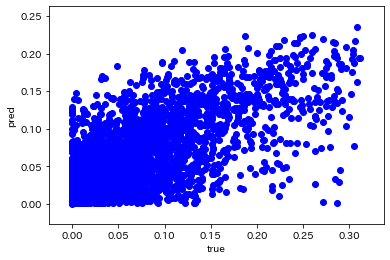

In [10]:
plt.scatter(Y_train, Y_pred,c='b')
plt.xlabel("true")
plt.ylabel("pred")
#plt.savefig()

# 結果（Sell）

In [7]:
Sell_X = X_train
Sell_Y = Y_train
Sell_set = pd.concat([Sell_Y,Sell_X],axis=1,sort=False).reset_index(drop=True)
#Sell_set.to_csv()

In [8]:
# Sell
best_params

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'metric': 'rmse',
 'random_state': 0,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 1.8847466786271963e-05,
 'lambda_l2': 1.1787256281854725e-08,
 'num_leaves': 62,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [11]:
pred_list_Sell = []
y_true = np.array(Y_train)

Y_pred = model.predict(X_train)
nrmse_score = np.sqrt(mean_squared_error(y_true, Y_pred))
pred_list_Sell.append(nrmse_score)

Text(0, 0.5, 'pred')

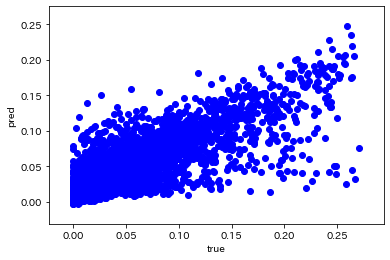

In [13]:
plt.scatter(Y_train, Y_pred,c='b');
plt.xlabel("true")
plt.ylabel("pred")
#plt.savefig()

# SHAPley(Buy)

In [11]:
import shap
shap.initjs()

In [12]:
# デフォルト設定
explainer = shap.TreeExplainer(model=models["Buy"])
exData = shap.sample(Buy_X,10000)
shap_v = explainer.shap_values(X=Buy_X)
Buy_shap_v = shap_v

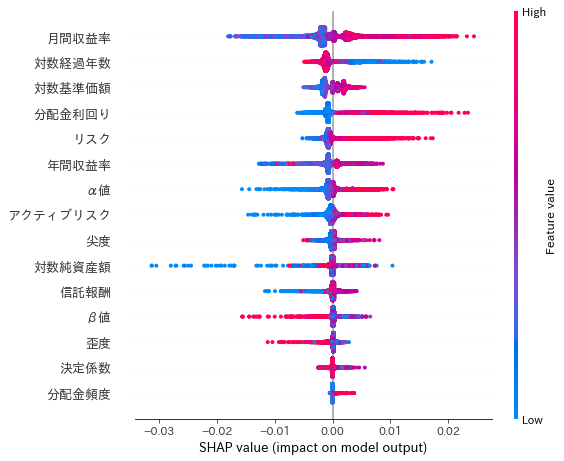

In [13]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=Buy_X.iloc[:,1:],feature_names=Buy_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

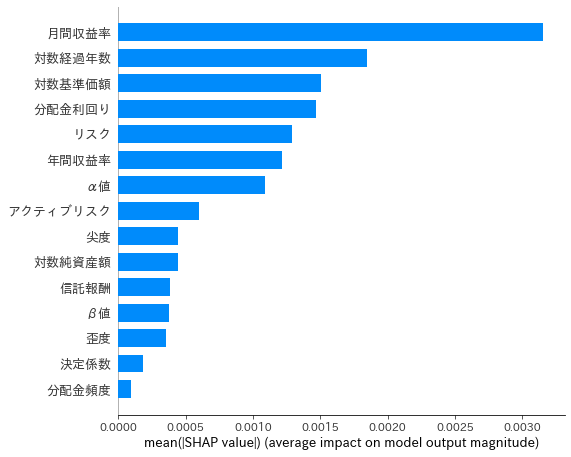

In [14]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=Buy_X.iloc[:,1:],feature_names=Buy_X.columns[1:],\
                  show=False,plot_type="bar",max_display=20)
# plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [15]:
# SHAP相関図の表示＆保存
def shap_plot(shap_v, X, mode, col_name, save):
    plt.figure(figsize=(15,15))
    shap.dependence_plot(ind=col_name, shap_values=shap_v,features=X,show=False,interaction_index=None)
    if save:
        plt.savefig(r"..\..\Fig\{}_{}.svg".format(mode,col_name)\
                    , dpi=200, bbox_inches="tight", pad_inches=0.1)

<Figure size 1080x1080 with 0 Axes>

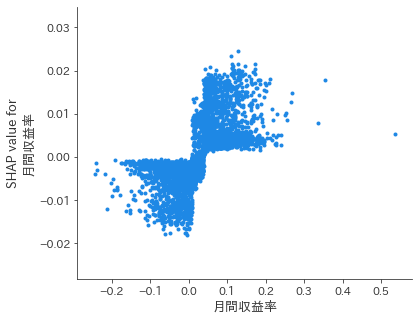

In [16]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '月間収益率', False)# 基準価額の値は対数変換されています

<Figure size 1080x1080 with 0 Axes>

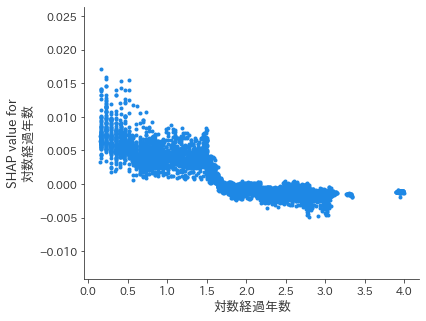

In [17]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数経過年数', False)

<Figure size 1080x1080 with 0 Axes>

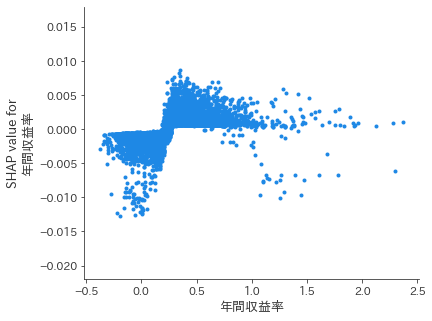

In [18]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '年間収益率', False)

<Figure size 1080x1080 with 0 Axes>

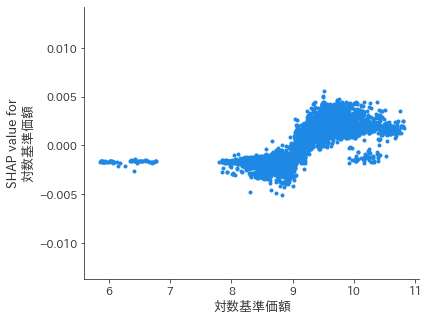

In [19]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

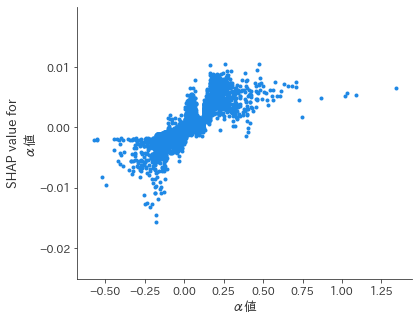

In [20]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', 'α値', False)

<Figure size 1080x1080 with 0 Axes>

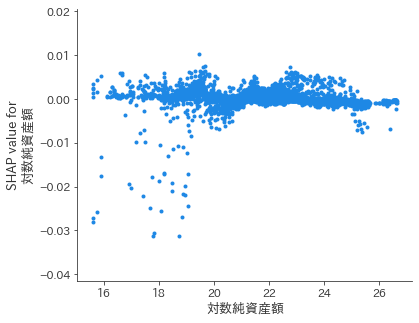

In [21]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '対数純資産額', False)

<Figure size 1080x1080 with 0 Axes>

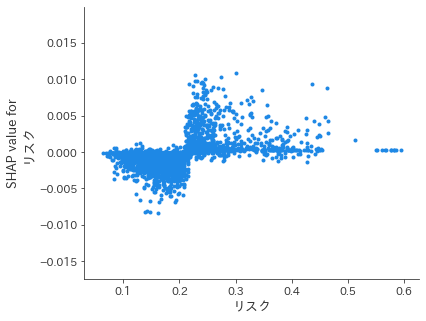

In [24]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', 'リスク',False)

<Figure size 1080x1080 with 0 Axes>

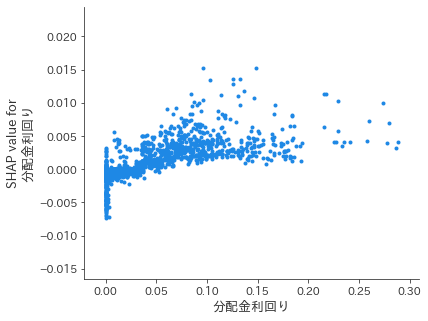

In [25]:
shap_plot(Buy_shap_v, Buy_X, 'Buy', '分配金利回り', False)

In [22]:
DF_Buy_shap = pd.DataFrame(Buy_shap_v,columns=Buy_X.columns[:])
DF_Buy_shap.to_csv("Buy_sv_term2.csv")

DF_Buy = pd.DataFrame(Buy_X,columns=Buy_X.columns[:])
DF_Buy.to_csv("Buy_term2.csv")

DF_Buy_shap

,設定額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,-0.017294,0.000136,-0.001610,0.002347,-0.001295,0.000423,0.000171,-0.000173,-0.000797,-0.001512,-0.000022,-0.000111,0.000075,0.000056,0.000135,-6.974176e-05
1,-0.018126,-0.000148,-0.002791,0.002396,-0.000992,0.000090,0.000209,0.000307,-0.000890,0.003608,0.000915,0.000239,-0.000651,-0.001885,0.000398,-7.222515e-05
2,-0.012144,0.000146,-0.001653,0.003159,-0.001234,-0.000594,0.000258,0.000319,-0.000792,-0.000935,0.000323,0.000279,-0.000022,-0.000608,0.000205,-5.358865e-05
3,-0.016139,0.000124,-0.001372,0.002099,-0.001338,-0.000315,0.000169,0.000280,-0.000699,-0.001693,-0.000045,0.000263,0.000011,-0.000042,0.000011,-5.460983e-05
4,0.037371,0.010389,0.003149,-0.000952,-0.001997,0.009935,0.000608,0.000936,-0.000360,0.008939,-0.000547,-0.000351,0.005609,0.007488,0.001089,5.576381e-04
5,-0.015361,0.000093,-0.001744,0.000333,-0.000680,-0.000439,0.000034,0.000259,-0.000770,-0.001004,-0.000713,0.000205,-0.000025,-0.000466,-0.000295,-2.909936e-05
6,-0.016358,0.000048,0.000056,0.002593,-0.001416,-0.000391,0.000189,-0.000149,-0.000713,-0.001763,-0.000412,0.000094,-0.000007,-0.000134,0.000166,-7.476506e-05
7,-0.016284,0.000053,-0.002132,0.002487,-0.001186,-0.000286,0.000151,-0.000322,-0.000900,-0.000181,-0.000807,0.000171,-0.000009,-0.000084,-0.000321,-2.929093e-05
8,-0.017544,0.000030,-0.001604,0.002264,-0.001152,-0.000590,0.000137,-0.000117,-0.000920,-0.000961,-0.000762,0.000161,0.000036,0.000163,0.000124,-1.794256e-05
9,-0.008449,-0.000093,-0.001351,0.000160,-0.000851,-0.000367,0.000124,0.000344,-0.000775,-0.001124,-0.000804,0.000297,-0.000054,-0.000567,-0.000255,-3.581092e-05


#  

## 特定ファンド

In [23]:
target_data_term2 = pd.read_csv(r"/Users/chuudoutakuma/投信資金フロー/中道/for_nakamichi/プログラム/allterm/target_data_term2.csv",index_col=0)

In [24]:
target_Buy_X = target_data_term2.drop(["ID", "ファンド名","設定額","月",\
                            "解約額", "解約額lag1", "販売手数料", "元本割れ頻度", "元本割れリスク", "シャープレシオ"],axis=1)
target_Buy_Y = target_data_term2['設定額']
target_Buy_set = pd.concat([target_Buy_Y,target_Buy_X],axis=1,sort=False).reset_index(drop=True)

In [25]:
explainer = shap.TreeExplainer(model=models["Buy"])
exData = shap.sample(target_Buy_X,10000)
shap_v = explainer.shap_values(X=target_Buy_X)
Buy_shap_v = shap_v

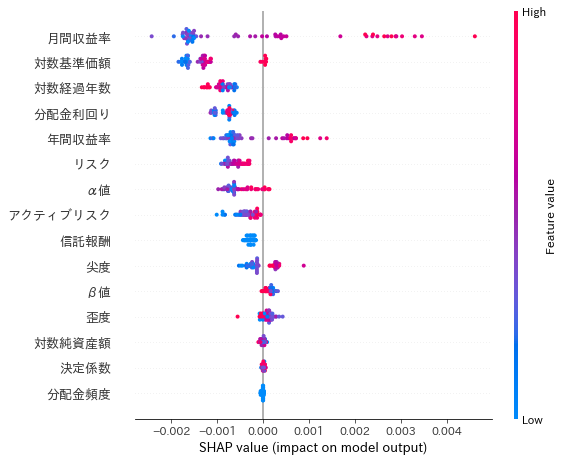

In [26]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Buy_shap_v[:,1:],\
                  features=target_Buy_X.iloc[:,1:],feature_names=target_Buy_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [27]:
DF_target_Buy_shap = pd.DataFrame(Buy_shap_v,columns=target_Buy_X.columns[:])
DF_target_Buy_shap.to_csv("target_Buy_sv_term2.csv")

DF_target_Buy = pd.DataFrame(target_Buy_X,columns=target_Buy_X.columns[:])
DF_target_Buy.to_csv("target_Buy_term2.csv")

DF_target_Buy_shap

,設定額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,-0.015922,3.055331e-05,-0.001654,0.000445,-0.000715,-0.000327,0.000150,-0.000128,-0.000880,-0.000599,-0.000717,-0.000009,-3.104419e-06,-0.000068,-0.000349,-8.523568e-06
1,-0.015029,6.239775e-05,-0.001344,0.000272,-0.000804,-0.000331,0.000171,-0.000098,-0.000880,-0.000574,-0.000757,-0.000013,-1.671129e-05,-0.000132,-0.000332,5.806520e-06
2,-0.016383,3.136057e-05,-0.001371,0.000507,-0.000717,-0.000308,0.000221,0.000276,-0.000735,-0.000745,-0.000768,0.000152,6.189848e-07,-0.000061,-0.000321,-8.523568e-06
3,-0.014194,-4.047967e-05,-0.001631,-0.001545,-0.000681,-0.000301,0.000113,-0.000255,-0.000727,-0.000770,-0.000533,0.000159,1.755712e-05,-0.000127,-0.000240,-4.789114e-05
4,-0.014664,-8.850987e-05,-0.001598,-0.001519,-0.000664,-0.000300,0.000128,-0.000265,-0.000727,-0.000838,-0.000435,0.000159,2.591977e-05,-0.000127,-0.000283,-5.288855e-05
5,-0.013791,-1.051888e-04,-0.001672,-0.001588,-0.000642,-0.000642,0.000123,-0.000219,-0.000737,-0.000716,-0.000341,0.000147,1.515666e-05,-0.000213,-0.000201,3.067419e-06
6,-0.014949,-5.878062e-05,-0.001648,-0.001213,-0.000655,-0.000786,0.000194,-0.000139,-0.000679,-0.000882,0.000030,0.000163,2.263237e-05,-0.000187,-0.000209,-1.126267e-05
7,-0.014600,-7.995369e-05,-0.001641,-0.001507,-0.000613,-0.000788,0.000120,-0.000132,-0.000675,-0.000889,0.000030,0.000147,2.263237e-05,-0.000182,-0.000210,-1.126267e-05
8,-0.013991,-3.503911e-05,-0.001770,-0.001599,-0.000755,-0.000770,-0.000073,0.000327,-0.000792,-0.000818,0.000015,0.000176,2.354311e-05,-0.000141,-0.000173,-1.126267e-05
9,-0.013830,-4.335521e-05,-0.001674,-0.001673,-0.000750,-0.000864,0.000090,0.000349,-0.000744,-0.000632,-0.000564,0.000217,-1.169054e-05,-0.000242,-0.000158,1.433819e-05


# SHAPley(Sell)

In [15]:
import shap
#plt.rcParams['font.family'] = "Yu Gothic"
shap.initjs()

In [18]:
# デフォルト設定
explainer = shap.TreeExplainer(model=models["Sell"])
exData = shap.sample(Sell_X,10000)
shap_v = explainer.shap_values(X=Sell_X)
Sell_shap_v = shap_v

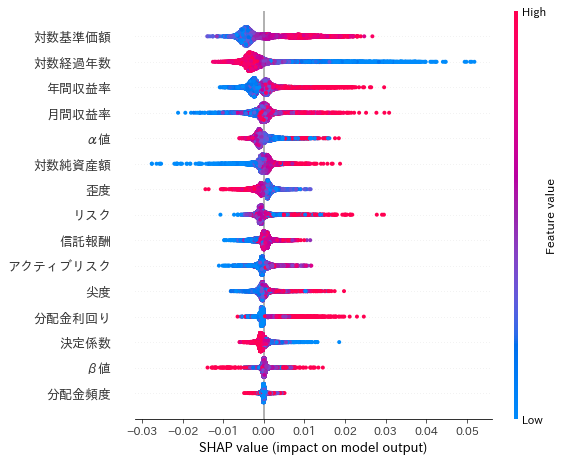

In [21]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Sell_shap_v[:,1:],\
                  features=Sell_X.iloc[:,1:],feature_names=Sell_X.columns[1:],\
                  show=False,max_display=20)
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

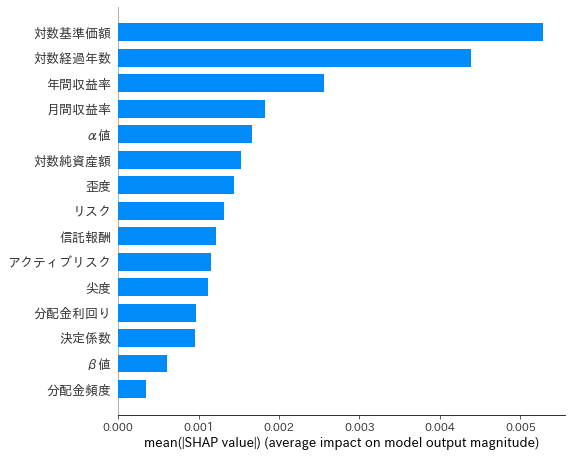

In [23]:
plt.figure(figsize=(15,15))
shap.summary_plot(shap_values=Sell_shap_v[:,1:],\
                  features=Sell_X.iloc[:,1:],feature_names=Sell_X.columns[1:],\
                  show=False,max_display=20,plot_type="bar")
#plt.savefig(PATH, dpi=200, bbox_inches="tight", pad_inches=0.1)

In [29]:
def shap_plot(shap_v, X, mode, col_name, save):
    plt.figure(figsize=(15,15))
    shap.dependence_plot(ind=col_name, shap_values=shap_v,features=X,show=False,interaction_index=None)
    if save:
        plt.savefig(r"..\..\Fig\{}_{}.svg".format(mode,col_name)\
                    , dpi=200, bbox_inches="tight", pad_inches=0.1)

<Figure size 1080x1080 with 0 Axes>

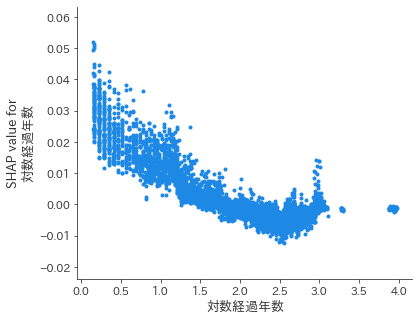

In [30]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '対数経過年数', False)

<Figure size 1080x1080 with 0 Axes>

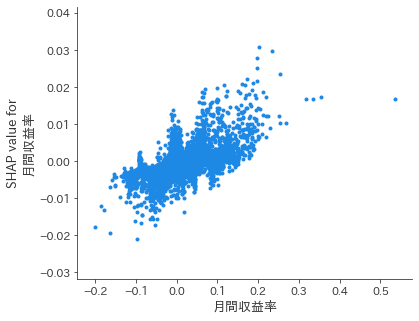

In [31]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '月間収益率', False)

<Figure size 1080x1080 with 0 Axes>

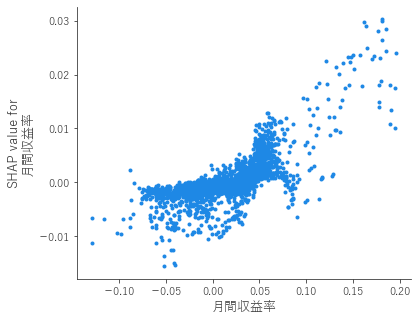

In [22]:
shap_plot(Sell_shap_v, X_test, 'Sell', '月間収益率', False)

<Figure size 1080x1080 with 0 Axes>

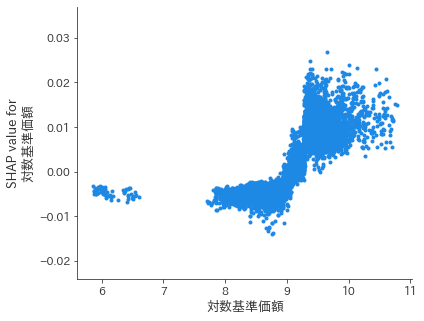

In [32]:
shap_plot(Sell_shap_v,Sell_X, 'Sell', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

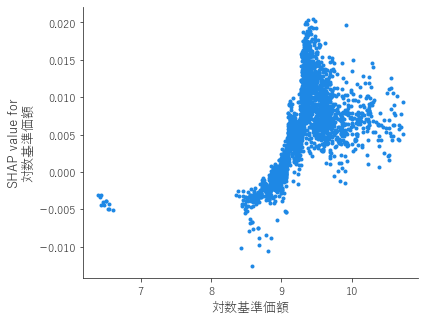

In [23]:
shap_plot(Sell_shap_v, X_test, 'Sell', '対数基準価額', False)

<Figure size 1080x1080 with 0 Axes>

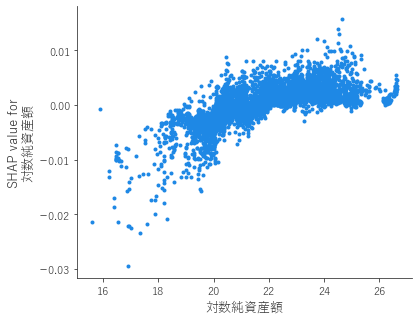

In [50]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '対数純資産額', True)

<Figure size 1080x1080 with 0 Axes>

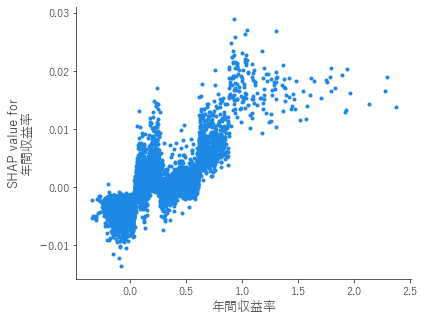

In [47]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '年間収益率', True)

<Figure size 1080x1080 with 0 Axes>

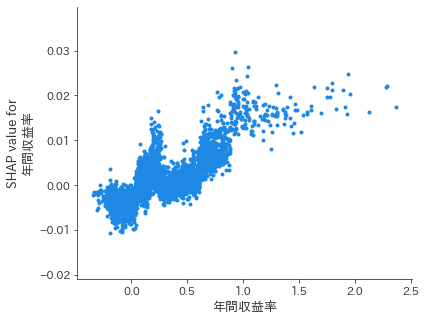

In [34]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '年間収益率', True)

<Figure size 1080x1080 with 0 Axes>

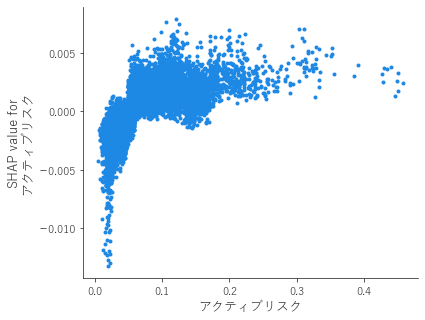

In [64]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'アクティブリスク', True)

<Figure size 1080x1080 with 0 Axes>

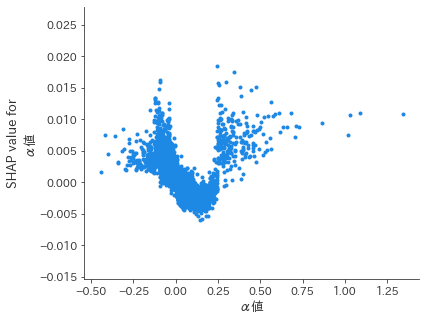

In [33]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'α値', True)

<Figure size 1080x1080 with 0 Axes>

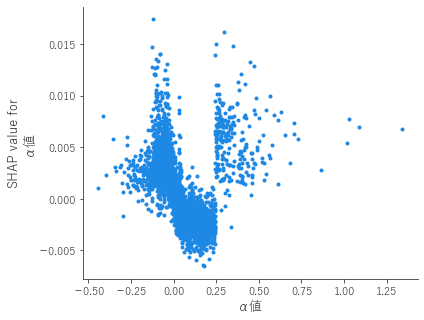

In [48]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', 'α値', True)

<Figure size 1080x1080 with 0 Axes>

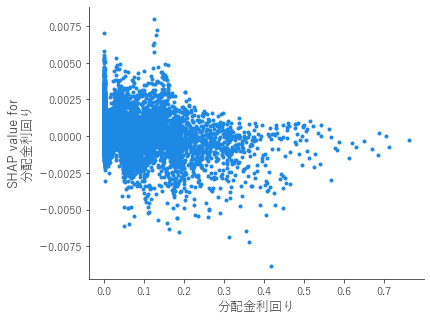

In [72]:
shap_plot(Sell_shap_v, Sell_X, 'Sell', '分配金利回り', False)

In [49]:
DF_Sell_shap = pd.DataFrame(Sell_shap_v,columns=Sell_X.columns[:])
DF_Sell_shap.to_csv()
DF_Sell_shap

,解約額lag1,対数純資産額,対数基準価額,月間収益率,年間収益率,リスク,歪度,尖度,分配金利回り,対数経過年数,α値,β値,決定係数,アクティブリスク,信託報酬,分配金頻度
0,0.019862,-0.000201,-0.005300,0.002988,0.001431,-0.000462,-0.002683,-0.004216,-0.000591,-0.005013,-0.002524,0.000580,-0.000274,0.001818,0.002326,0.000230
1,0.022761,0.002025,-0.005464,-0.001104,0.000008,0.000147,0.000283,0.005095,-0.000676,0.014170,-0.000733,-0.000300,-0.000792,-0.000671,0.003361,0.000321
2,-0.005590,0.000781,-0.005542,-0.000166,0.000688,-0.000386,-0.000521,0.001728,-0.000501,-0.004101,-0.001097,0.000029,-0.000076,0.000204,0.000351,0.000155
3,-0.004679,-0.000085,-0.005819,-0.000309,0.000979,-0.000585,0.001262,-0.001125,-0.000398,-0.003099,-0.001718,0.000023,0.000393,0.001060,-0.000859,0.000430
4,-0.003119,0.002625,-0.004487,-0.000096,0.001360,-0.000722,-0.000177,-0.001432,-0.000406,-0.001344,-0.000871,0.000254,-0.000495,-0.001249,0.000404,-0.000116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11400,0.020089,-0.000062,0.007273,0.002546,-0.004850,-0.001187,-0.001986,0.001336,-0.000159,-0.002462,0.002286,-0.001279,0.003151,-0.001548,-0.002860,-0.000228
11401,0.020520,0.000427,-0.006735,-0.001256,0.001205,-0.002090,-0.001415,0.005641,0.000047,-0.002750,0.001160,0.000853,0.005721,0.000720,0.000958,-0.000018
11402,0.044422,0.006032,0.022504,0.003597,0.007003,0.008174,0.005411,0.005479,0.001060,0.004584,0.012105,0.005634,0.011959,0.009664,0.003488,-0.000132
11403,0.035301,0.005905,0.016795,0.004753,-0.000307,-0.002053,0.000631,0.001531,0.000806,0.003226,0.006854,0.000907,-0.001123,-0.010146,0.000665,0.000505
